In [ ]:
import mediapipe_model as mm

/Users/anabellafalk/cs4701/cs4701-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Data

In [2]:
path = mm.download_dataset_synthetic()

Path to dataset files: /Users/anabellafalk/.cache/kagglehub/datasets/lexset/synthetic-asl-alphabet/versions/3


In [3]:
dat = mm.preprocess_dataset_synthetic(path, mm.initialize_transformation())

In [4]:
loader_tr, loader_val = mm.test_train_split(dat)

### Crop Image

In [9]:
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [ ]:
# Set index of single image
i = 0

images, labels = next(iter(loader_tr))
img = images[i].squeeze()
img = img.permute(1, 2, 0)  

# Reformat image data
img_np = np.array(img * 255, order='C').astype(np.uint8)
img_mp = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_np)

In [ ]:
# Run mediapipe
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options)
detector = vision.HandLandmarker.create_from_options(options)

detection_result = detector.detect(img_mp)

I0000 00:00:1765549221.195173 11531292 gl_context.cc:369] GL version: 2.1 (2.1 INTEL-22.5.10), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine
W0000 00:00:1765549221.229826 11539930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765549221.250016 11539937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [7]:
img.shape

torch.Size([3, 512, 513])

In [19]:
detection_result.hand_landmarks[0]

[NormalizedLandmark(x=0.5487675666809082, y=0.7715103030204773, z=2.312054618869297e-07, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.49855291843414307, y=0.7349492311477661, z=-0.04546618089079857, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.45327967405319214, y=0.6789053678512573, z=-0.07548678666353226, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.40778714418411255, y=0.6306537389755249, z=-0.0995573103427887, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.35059481859207153, y=0.6073523759841919, z=-0.12220537662506104, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.48336726427078247, y=0.5908377766609192, z=-0.07311725616455078, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.4660414755344391, y=0.4887293875217438, z=-0.12088003009557724, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.4550420641899109, y=0.42918187379837036, z=-0.15033894777297974, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.4498279094696045, 

In [ ]:
# Get bounding box from mediapipe result
w = img_np.shape[0]
h = img_np.shape[1]

# Collect pixel coordinates for bounding box
x_coords = [int(lm.x * w) for lm in detection_result.hand_landmarks[0]]
y_coords = [int(lm.y * h) for lm in detection_result.hand_landmarks[0]]
                    
# Bounding box
x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)

In [ ]:
# Crop image based on bounding box
img_crop = img_np[y_min:y_max, x_min:x_max]

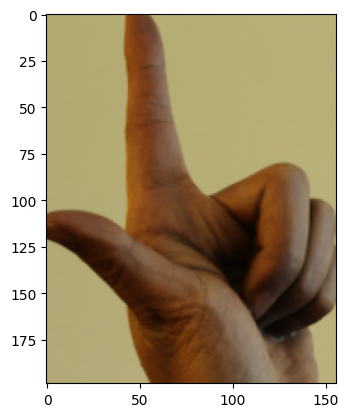

In [ ]:
import matplotlib.pyplot as plt

# Veiw cropped image
plt.imshow(img_crop)
plt.show()

In [51]:
import cv2

# Resize to model input size
model_in_h = 200
model_in_w = 200

img_input = cv2.resize(img_crop, (model_in_h, model_in_w)) 

In [53]:
import torch

# Normalize for model input
img_input = torch.from_numpy(img_input).float() / 255.0 # normalize to [0,1]
img_input = (img_input - 0.5) / 0.5 # normallize to [-1,1]
img_input = img_input.permute(2, 0, 1) # change to (Channels, Height, Width) from (H,W,C)
img_input = img_input.unsqueeze(0) # adding batch dimension (though this can be done with tensor too)

### Process All Images

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def crop_image(img_np, res, model_in_h = 200, model_in_w = 200):
    # Get bounding box from mediapipe result
    h = img_np.shape[0]
    w = img_np.shape[1]

    # Collect pixel coordinates for bounding box
    x_coords = [int(lm.x * w) for lm in res[0]]
    y_coords = [int(lm.y * h) for lm in res[0]]
                                
    # Bounding box
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # Crop image based on bounding box
    img_crop = img_np[y_min:y_max, x_min:x_max]
    
    if img_crop.size > 0:
        # Resize to model input size
        img_input = cv2.resize(img_crop, (model_in_h, model_in_w)) 

        # Normalize for model input
        img_input = torch.from_numpy(img_input).float() / 255.0 # normalize to [0,1]
        img_input = (img_input - 0.5) / 0.5 # normallize to [-1,1]
        img_input = img_input.permute(2, 0, 1) # change to (Channels, Height, Width) from (H,W,C)
        img_input = img_input.unsqueeze(0) # adding batch dimension (though this can be done with tensor too)

        return img_input
    else: 
        return None


def crop_batch(images, labels, detector):
    imgs_np = (images.permute(0,2,3,1) * 255).byte().cpu().numpy()

    # Iterate through images in batch
    img_batch = []
    labels_batch = []
    for j, img_np in enumerate(imgs_np):
        # Convert to mediapipe format
        img_np = np.ascontiguousarray(img_np)
        img_mp = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_np)

        # Get embeddings
        res = (detector.detect(img_mp)).hand_landmarks           

        # Add cropped image to result tensor if detected
        if res:
            img_input = crop_image(img_np, res)

            if img_input is not None:
                img_batch.append(img_input)
                labels_batch.append(labels[j])

    return img_batch, labels_batch


def get_crops(loader):
    base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
    options = vision.HandLandmarkerOptions(base_options=base_options)
    detector = vision.HandLandmarker.create_from_options(options)

    # Initialize result
    img_mp = []
    labels_mp = []

    # Call thread on each batch
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = {executor.submit(crop_batch, images, labels, detector) for images, labels in tqdm(loader)}

        # Combine output
        for f in tqdm(as_completed(futures), total=len(futures)):
            dat_batch, img_batch, labels_batch = f.result()
            img_mp.append(torch.cat(img_batch, dim=0))
            labels_mp.append(torch.tensor(labels_batch))

    return img_mp, labels_mp

In [70]:
img_mp, labels_mp = get_crops(loader_tr)

I0000 00:00:1765556709.708709 11531292 gl_context.cc:369] GL version: 2.1 (2.1 INTEL-22.5.10), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine
W0000 00:00:1765556709.752188 11657697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765556709.786043 11657696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 270/270 [05:10<00:00,  1.15s/it]


### Get Distribution of Data

In [130]:
mm.approximate_undetected(loader_tr, img_mp)

Approximate number of undetected images: 1800
Approximate percentage of images undetected: 10.42%


In [137]:
reverse_map = {dat.class_to_idx[c]: c for c in dat.class_to_idx.keys()}

counts = {c:0 for c in dat.class_to_idx.keys()}
for x in labels_mp:
  v,c = torch.unique(x, return_counts=True)

  for i in range(len(v)):
    key = reverse_map[int(v[i])]
    counts[key] = counts[key] + int(c[i])

In [138]:
counts

{'A': 693,
 'B': 645,
 'C': 691,
 'D': 615,
 'E': 565,
 'F': 654,
 'G': 713,
 'H': 698,
 'I': 654,
 'K': 656,
 'L': 629,
 'M': 613,
 'N': 657,
 'O': 656,
 'P': 621,
 'Q': 663,
 'R': 633,
 'S': 647,
 'T': 691,
 'U': 639,
 'V': 614,
 'W': 645,
 'X': 606,
 'Y': 582}

In [71]:
torch.save((img_mp, labels_mp), "crops.pt")

# Fit Model

In [77]:
import torch.nn as nn
import torch.optim as optim 

In [ ]:
# Initialize Conv NN
num_classes = 24

# Note: output channels are arbitrary
conv_model = nn.Sequential(
        # 3 input channels for RGB
        nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1), 
        nn.ReLU(),
        nn.MaxPool2d(2), 
        # output dim ~50
        
        nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # output dim ~12

        nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # output dim ~3

        nn.Flatten(),
        nn.Linear(128*3*3, 256),
        nn.ReLU(),

        nn.Linear(256, num_classes)
    )

In [116]:
# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_model.parameters())

#### Model Trained in Google Colab

In [ ]:
# Fit model on data
NUM_EPOCH = 50
count = 0
for epoch in tqdm(range(NUM_EPOCH)):
    curr_loss = 0
    for i, img in enumerate(img_mp): # enumerate in batch size
            labels_batch = labels_mp[i]

            optimizer.zero_grad()

            outputs = conv_model(img)
            loss = criterion(outputs, labels_batch)
            
            loss.backward()
            optimizer.step()
            
            curr_loss += loss.item()

    count += 1
    print("loss: " + str(curr_loss))
    curr_loss = 0

#### Load in Pretrained Model

In [114]:
conv_model = torch.load("models/cnn_model_3.pt")

# Evaluate Model

### Train Accuracy

In [124]:
img_mp, labels_mp = torch.load("crops.pt")

In [126]:
mode = "Train"
correct = 0
total = 0

for i, img in tqdm(enumerate(img_mp)):
    labels_batch = labels_mp[i]

    outputs = conv_model(img)
    _, predicted = torch.max(outputs, 1)
        
    correct += (predicted == labels_batch).sum().item()
    total += labels_batch.shape[0]

accuracy = correct / total
print("{mode} Accuracy: " + str(accuracy))

270it [00:43,  6.14it/s]

{mode} Accuracy: 1.0


In [127]:
reverse_map = {dat.class_to_idx[c]: c for c in dat.class_to_idx.keys()}
correct = {c:0 for c in dat.class_to_idx.keys()}
total = {c:0 for c in dat.class_to_idx.keys()}

conv_model.eval()
with torch.no_grad():
    for i, img in tqdm(enumerate(img_mp)):
        labels_batch = labels_mp[i]

        outputs = conv_model(img)
        _, predicted = torch.max(outputs, 1)

        for lab, pred in zip(labels_batch, predicted):
            if lab == pred:
                correct[reverse_map[lab.item()]] += 1
            total[reverse_map[lab.item()]] += 1
class_accuracy = {c: correct[c] / total[c] if total[c] > 0 else 0 for c in total.keys()}

for c,acc in class_accuracy.items():
    print(f"{c} Accuracy: {acc:.2%}")

270it [00:44,  6.12it/s]

A Accuracy: 100.00%
B Accuracy: 100.00%
C Accuracy: 100.00%
D Accuracy: 100.00%
E Accuracy: 100.00%
F Accuracy: 100.00%
G Accuracy: 100.00%
H Accuracy: 100.00%
I Accuracy: 100.00%
K Accuracy: 100.00%
L Accuracy: 100.00%
M Accuracy: 100.00%
N Accuracy: 100.00%
O Accuracy: 100.00%
P Accuracy: 100.00%
Q Accuracy: 100.00%
R Accuracy: 100.00%
S Accuracy: 100.00%
T Accuracy: 100.00%
U Accuracy: 100.00%
V Accuracy: 100.00%
W Accuracy: 100.00%
X Accuracy: 100.00%
Y Accuracy: 100.00%


### Process Validation Data

In [80]:
img_mp_val, labels_mp_val = get_crops(loader_val)

I0000 00:00:1765562284.471331 11531292 gl_context.cc:369] GL version: 2.1 (2.1 INTEL-22.5.10), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine
W0000 00:00:1765562284.587963 11743232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765562284.625688 11743232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 68/68 [01:09<00:00,  1.03s/it]


In [131]:
mm.approximate_undetected(loader_val, img_mp_val)

Approximate number of undetected images: 509
Approximate percentage of images undetected: 11.7%


In [135]:
counts_val = {c:0 for c in dat.class_to_idx.keys()}
for x in labels_mp_val:
  v,c = torch.unique(x, return_counts=True)

  for i in range(len(v)):
    key = reverse_map[int(v[i])]
    counts_val[key] = counts_val[key] + int(c[i])

In [136]:
counts_val

{'A': 143,
 'B': 165,
 'C': 163,
 'D': 164,
 'E': 150,
 'F': 136,
 'G': 164,
 'H': 166,
 'I': 172,
 'K': 159,
 'L': 175,
 'M': 144,
 'N': 183,
 'O': 161,
 'P': 162,
 'Q': 158,
 'R': 186,
 'S': 157,
 'T': 158,
 'U': 171,
 'V': 151,
 'W': 159,
 'X': 156,
 'Y': 140}

In [81]:
torch.save((img_mp_val, labels_mp_val), "crops_val.pt")

### Validation Accuracy

In [ ]:
mode = "Validation"
correct = 0
total = 0

for i, igm in tqdm(enumerate(img_mp_val)):
    labels_batch = labels_mp_val[i]

    outputs = conv_model(img)
    _, predicted = torch.max(outputs, 1)
        
    correct += (predicted == labels_batch).sum().item()
    total += labels_batch.shape[0]

accuracy = correct / total
print("{mode} Accuracy: " + str(accuracy))

68it [00:08,  8.34it/s]

{mode} Accuracy: 0.9573250065053344


In [ ]:
reverse_map = {dat.class_to_idx[c]: c for c in dat.class_to_idx.keys()}
correct = {c:0 for c in dat.class_to_idx.keys()}
total = {c:0 for c in dat.class_to_idx.keys()}

conv_model.eval()
with torch.no_grad():
    for i, img in tqdm(enumerate(img_mp_val)):
        labels_batch = labels_mp_val[i]

        outputs = conv_model(img)
        _, predicted = torch.max(outputs, 1)

        for lab, pred in zip(labels_batch, predicted):
            if lab == pred:
                correct[reverse_map[lab.item()]] += 1
            total[reverse_map[lab.item()]] += 1
class_accuracy = {c: correct[c] / total[c] if total[c] > 0 else 0 for c in total.keys()}

for c,acc in class_accuracy.items():
    print(f"{c} Accuracy: {acc:.2%}")

68it [00:07,  9.40it/s]

A Accuracy: 90.91%
B Accuracy: 96.36%
C Accuracy: 99.39%
D Accuracy: 93.90%
E Accuracy: 96.67%
F Accuracy: 86.76%
G Accuracy: 90.24%
H Accuracy: 100.00%
I Accuracy: 94.19%
K Accuracy: 96.23%
L Accuracy: 96.57%
M Accuracy: 96.53%
N Accuracy: 97.27%
O Accuracy: 98.76%
P Accuracy: 98.15%
Q Accuracy: 96.84%
R Accuracy: 95.16%
S Accuracy: 95.54%
T Accuracy: 97.47%
U Accuracy: 97.66%
V Accuracy: 94.70%
W Accuracy: 98.11%
X Accuracy: 96.15%
Y Accuracy: 91.43%
